# 04 — Model Evaluation

This notebook evaluates the trained U-Net model on validation data.

We compute segmentation-specific metrics including:
- Intersection over Union (IoU)
- Dice Coefficient

We also visualize predictions alongside ground truth masks to qualitatively assess model performance.

Accuracy is not used because it is misleading for multi-class semantic segmentation tasks.

## Section 1 - Imports and paths

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
# Project root is parent of notebooks/
PROJECT_ROOT = Path.cwd().parent

MODEL_PATH = PROJECT_ROOT / "models" / "unet_deepglobe.pth"
DATA_DIR   = PROJECT_ROOT / "data" / "processed" / "valid"

assert MODEL_PATH.exists(), f"Model not found at {MODEL_PATH}"
assert DATA_DIR.exists(), f"Validation data not found at {DATA_DIR}"

print("Paths verified.")

Paths verified.


## Section 2 - Model definition
The U-Net architecture below is **identical** to the one used during training. This is critical for correctly loading the saved model weights without errors.

In [21]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(3, 64)
        self.enc2 = block(64, 128)
        self.enc3 = block(128, 256)
        self.enc4 = block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = block(128, 64)

        self.out = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b  = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)

## Load the model trained on 03_Model training
The trained model is loaded using the saved state dictionary. The model is set to evaluation mode to disable gradient computation.

In [22]:
model = UNet(num_classes=7).to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.eval()
print("Model loaded successfully.")

C:\Users\ibaan\AppData\Local\Temp\ipykernel_27316\444802190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


Model loaded successfully.


## Section 3 - Validation dataset
The validation dataset is loaded without augmentation to ensure a fair and unbiased evaluation of model performance.

In [23]:
# Dataset and dataloader
from torch.utils.data import Dataset, DataLoader

class DeepGlobeEvalDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images = sorted(images_dir.glob("*.jpg"))
        self.masks  = sorted(masks_dir.glob("*.npy"))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(str(self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

        mask = np.load(self.masks[idx])
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [24]:
val_dataset = DeepGlobeEvalDataset(
    DATA_DIR / "images",
    DATA_DIR / "masks"
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False
)

print("Validation samples:", len(val_dataset))

Validation samples: 0


## Section 4 - Metrics
We use Intersection over Union (IoU) and Dice coefficient to quantitatively evaluate segmentation quality.

In [25]:
# Metrics functions
def iou_score(pred, target, num_classes=7):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()

        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)


def dice_score(pred, target, num_classes=7):
    dices = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls

        intersection = (pred_inds & target_inds).sum().item()
        total = pred_inds.sum().item() + target_inds.sum().item()

        if total == 0:
            dices.append(np.nan)
        else:
            dices.append(2 * intersection / total)

    return np.nanmean(dices)
print("Metrics functions defined.")

Metrics functions defined.


## Run evaluation
The model is evaluated on the validation dataset and mean IoU and Dice scores are computed.


In [26]:
iou_scores = []
dice_scores = []

with torch.no_grad():
    for images, masks in tqdm(val_loader):
        images = images.to(device)
        masks  = masks.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        iou_scores.append(iou_score(preds.cpu(), masks.cpu()))
        dice_scores.append(dice_score(preds.cpu(), masks.cpu()))

0it [00:00, ?it/s]


In [27]:
print(f"Mean IoU  : {np.mean(iou_scores):.4f}")
print(f"Mean Dice: {np.mean(dice_scores):.4f}")

Mean IoU  : nan
Mean Dice: nan


c:\Users\ibaan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ibaan\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Section 5 - Visualization
Sample predictions are visualized to qualitatively assess the spatial accuracy of the segmentation results.


In [28]:
def visualize_sample(idx=0):
    image, mask = val_dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image)
        pred = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
    axs[0].set_title("Satellite Image")

    axs[1].imshow(mask)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred)
    axs[2].set_title("Prediction")

    for ax in axs:
        ax.axis("off")

    plt.show()

In [30]:
print("Images found:", len(val_dataset.images))
print("Masks found :", len(val_dataset.masks))

Images found: 0
Masks found : 0


## Section 6 - Recreating the Validation Split

During training, the dataset was split into training and validation sets in memory rather than being saved into separate folders on disk.

To ensure a fair and consistent evaluation, the same validation split is recreated here using the same random seed. This guarantees that the model is evaluated on exactly the same samples it has not seen during training.

In [31]:
from sklearn.model_selection import train_test_split
import os

TRAIN_DIR = PROJECT_ROOT / "data" / "raw" / "train"

all_images = sorted([
    f for f in os.listdir(TRAIN_DIR)
    if f.endswith("_sat.jpg")
])

_, val_files = train_test_split(
    all_images,
    test_size=0.2,
    random_state=42
)

print("Validation samples:", len(val_files))

Validation samples: 161


## Validation Dataset Construction

The validation dataset is loaded directly from the raw training directory. Each satellite image is paired with its corresponding segmentation mask using a consistent filename convention.

No data augmentation is applied at this stage to ensure an unbiased evaluation of model performance.

In [32]:
from torch.utils.data import Dataset, DataLoader
import cv2

class DeepGlobeDataset(Dataset):
    def __init__(self, data_dir, file_list):
        self.data_dir = data_dir
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        mask_name = img_name.replace("_sat.jpg", "_mask.png")

        image = cv2.imread(str(self.data_dir / img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

        mask = cv2.imread(str(self.data_dir / mask_name))
        mask = mask[:, :, 0]  # single channel
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

## Section 7 - Validation DataLoader

A DataLoader is used to efficiently iterate over the validation dataset. The batch size is set to one to allow precise metric computation and visual inspection of individual predictions.

In [33]:
val_dataset = DeepGlobeDataset(TRAIN_DIR, val_files)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False
)

print("Validation dataset ready.")

Validation dataset ready.


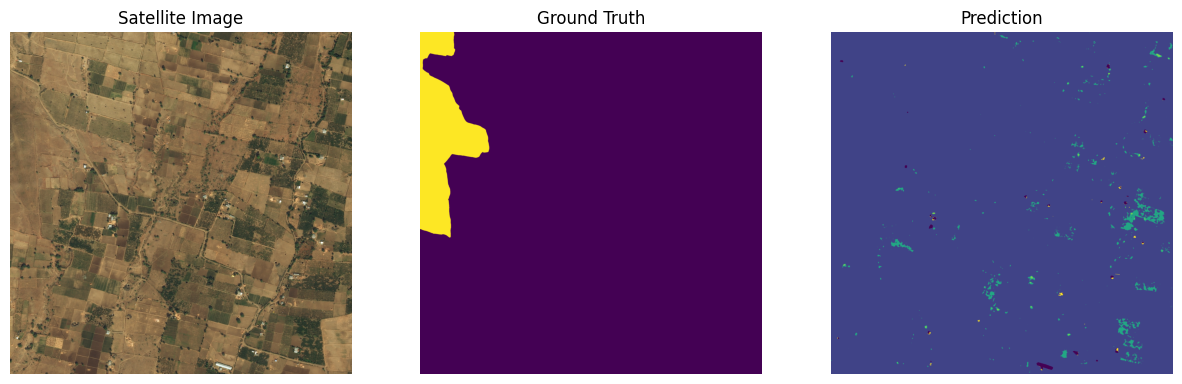

In [34]:
visualize_sample(0)

## Qualitative Result Interpretation

The left image shows the original satellite scene, which consists primarily of agricultural land with relatively uniform texture and limited urban structures. The middle image represents the ground truth land-cover mask, where most of the region belongs to a dominant class, with a small portion of a different class visible near the boundary.

The predicted segmentation (right) correctly captures the dominant land-cover class across the majority of the image, indicating that the model has learned the overall spatial and spectral characteristics of the scene. However, smaller regions and fine boundaries are fragmented or missed, suggesting that the model struggles with minority classes and subtle transitions between land-cover types.

This behavior is expected at the current training stage and reflects class imbalance within the dataset as well as the limited number of training epochs. Overall, the prediction demonstrates that the model has learned meaningful global patterns, while finer segmentation accuracy can be improved with additional training, data augmentation, or class-balanced loss functions.